### calculate the leadtime-dependent climatological terciles, deciles and percentiles (0.02, then 0.05 to 0.95 with 0.05 step) from the individual GCMs' hindcast dataset (period 1993 - 2016) for admin areas  

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline

### os and standard libraries 
import os
import sys
from collections import OrderedDict
from itertools import product

### datetimes
from datetime import datetime, timedelta

### scipy
import numpy as np
import pandas as pd
import xarray as xr
import geopandas as gpd
import cartopy.crs as ccrs
import dask
from dask.diagnostics import ProgressBar
from tqdm import tqdm

### plotting
from matplotlib import pyplot as plt
import matplotlib
import seaborn as sns


In [3]:
import pathlib

HOME = pathlib.Path.home()
CWD = pathlib.Path.cwd() 

In [4]:
sys.path.append('../../') 

In [5]:
from ICU_Water_Watch import geo, C3S, domains, plot, utils

/home/nicolasf/mambaforge/envs/ICU_ops/lib/python3.9/site-packages/statsmodels/compat/pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


### list of GCMs with complete hindcast period 

### PARAMETERS FOR PAPERMILL 

In [6]:
provider = 'CDS'
varname = 'tprate'
GCM = 'ECMWF'
quantiles = 'quartile'
country = "Papua New Guinea"
admin = "Islands Region"

In [7]:
gcm_path = pathlib.Path(f'/media/nicolasf/END19101/ICU/data/{provider}/operational/hindcasts')

In [8]:
dpath = gcm_path.joinpath(GCM).joinpath(varname.upper())

In [9]:
print(dpath)

/media/nicolasf/END19101/ICU/data/CDS/operational/hindcasts/ECMWF/TPRATE


### get the list of files 

In [10]:
lfiles = list(dpath.glob(f"ensemble_seas_forecasts_{varname}_from_*.netcdf"))

In [11]:
dset = xr.open_dataset(lfiles[0], engine='netcdf4')

In [12]:
dset = C3S.preprocess_GCM(dset)

In [13]:
dset = C3S.convert_rainfall(dset)


unit is m s**-1, converting to mm/day

now converting to mm/month, converted precipitation will be held in var = precip


In [14]:
dset.info

<bound method Dataset.info of <xarray.Dataset>
Dimensions:  (time: 1, lon: 121, lat: 81, member: 25, step: 5)
Coordinates:
  * time     (time) datetime64[ns] 1993-01-01
  * lon      (lon) float32 120.0 121.0 122.0 123.0 ... 237.0 238.0 239.0 240.0
  * lat      (lat) float32 -50.0 -49.0 -48.0 -47.0 -46.0 ... 27.0 28.0 29.0 30.0
  * member   (member) int32 0 1 2 3 4 5 6 7 8 9 ... 16 17 18 19 20 21 22 23 24
  * step     (step) int64 1 2 3 4 5
Data variables:
    precip   (time, step, member, lat, lon) float64 128.9 108.7 ... 3.533 3.134
Attributes:
    Conventions:  CF-1.6
    history:      2022-01-17 01:17:57 GMT by grib_to_netcdf-2.23.0: /opt/ecmw...>

### read the coastlines

In [15]:
coastlines_dpath = pathlib.Path('/home/nicolasf/operational/ICU/development/hotspots/data/shapefiles/Admin_boundaries/Coastlines')

In [16]:
shapefile = gpd.read_file(coastlines_dpath.joinpath('ICU_admin_geometries0_360.shp'))

In [17]:
shapefile

,id,Country,Admin_boun,geometry
0,1,Northern Mariana Islands,Southern Islands,"MULTIPOLYGON (((145.13454 14.13935, 145.13472 ..."
1,2,Northern Mariana Islands,Northern Islands,"MULTIPOLYGON (((146.05832 16.01259, 146.05590 ..."
2,3,Guam,Guam,"MULTIPOLYGON (((144.65813 13.23972, 144.65000 ..."
3,4,Palau,Babeldaob region,"MULTIPOLYGON (((134.12425 6.92185, 134.12468 6..."
4,5,Palau,South-west Islands,"MULTIPOLYGON (((131.81201 2.97124, 131.81115 2..."
...,...,...,...,...
68,24,Cook Islands,Northern Cook Islands,"MULTIPOLYGON (((196.88468 -13.33285, 196.88385..."
69,70,FSM,Kapingamarangi,"MULTIPOLYGON (((154.77861 1.02694, 154.78083 1..."
70,71,Marshall Islands,Southern Marshall Islands,"MULTIPOLYGON (((168.76519 4.60420, 168.76501 4..."
71,72,Marshall Islands,Central Marshall Islands,"MULTIPOLYGON (((168.76889 7.28056, 168.76944 7..."


In [18]:
country_col = 'Country'
admin_col = 'Admin_boun'

In [19]:
shapefile.loc[:,f"{admin_col}"] = shapefile.loc[:,f"{admin_col}"].str.replace("'","")

### restrict to country 

In [20]:
sub = shapefile.query(f"Country == '{country}'")

### restrict to administrative area 

In [21]:
shape = sub.query(f"{admin_col} == '{admin}'")

<AxesSubplot:>

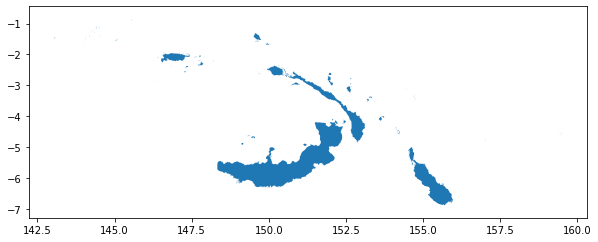

In [22]:
shape.plot(figsize=(10,10))

In [23]:
original_shape = shape.copy()

### for Island groups consituted of very small islands / atolls, we don't filter OUT the geometries, we actually buffer them  so that they can match the resolution of the GCM (once interpolated)

In [24]:
float(shape.to_crs('EPSG:3857').area / 10**6)

57820.77035999287

In [25]:
shape = shape.buffer(0.25)

In [26]:
# if float(shape.to_crs('EPSG:3857').area / 10**6) < 2000: 
#     shape = shape.buffer(0.25)
# else: 
#     shape = geo.filter_by_area(shape, min_area=500)

<AxesSubplot:>

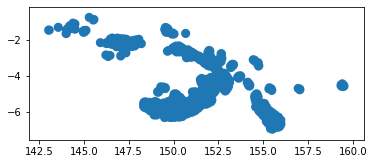

In [27]:
shape.plot()

### we use these filtered geometries to mask the GCM hindcast dataset

#### Note that the GCM dataset is first interpolated to 5X its original resolution 

### do we really need the 15km buffer now that we have the 0.25 degree buffer ? 

In [28]:
dset, domain = geo.mask_dataset(dset, shape, coastline_buffer=15)

/home/nicolasf/operational/ICU/development/hotspots/code/ICU_Water_Watch/notebooks/verification/../../ICU_Water_Watch/geo.py:303: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  items = list(element)
/home/nicolasf/operational/ICU/development/hotspots/code/ICU_Water_Watch/notebooks/verification/../../ICU_Water_Watch/geo.py:303: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  items = list(element)


In [29]:
dset

<xarray.Dataset>
Dimensions:  (time: 1, member: 25, step: 5, lat: 45, lon: 95)
Coordinates:
  * time     (time) datetime64[ns] 1993-01-01
  * member   (member) int32 0 1 2 3 4 5 6 7 8 9 ... 16 17 18 19 20 21 22 23 24
  * step     (step) int64 1 2 3 4 5
  * lon      (lon) float64 142.0 142.2 142.4 142.6 ... 159.4 159.6 159.8 160.0
  * lat      (lat) float64 -8.0 -7.818 -7.636 -7.455 ... -0.3636 -0.1818 0.0
Data variables:
    precip   (time, step, member, lat, lon) float64 nan nan nan ... nan nan nan
    mask     (lat, lon) float64 nan nan nan nan nan nan ... nan nan nan nan nan
Attributes:
    Conventions:  CF-1.6
    history:      2022-01-17 01:17:57 GMT by grib_to_netcdf-2.23.0: /opt/ecmw...

### number of grid points 

In [30]:
dset['mask'].attrs['cells']

893

### plots the precipitation field for one time step, leadtime and member 

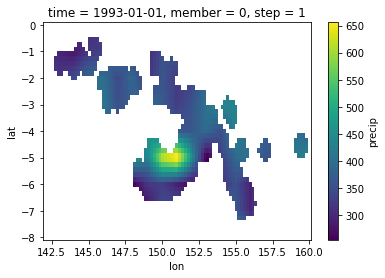

In [31]:
dset.isel(time=0, step=0, member=0)['precip'].plot()

In [32]:
mat = dset.isel(time=0, step=0, member=0)['precip']

In [33]:
mask = mat.where(np.isnan(mat), other=1)

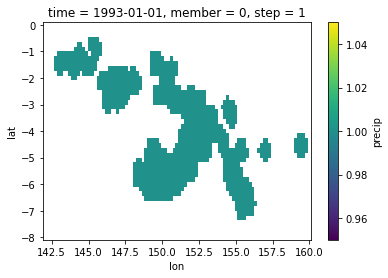

In [34]:
mask.plot()

### read the enclosing administrative area 

In [35]:
dpath_admin = pathlib.Path(HOME.joinpath('operational/ICU/development/hotspots/data/shapefiles/Admin_boundaries')) 

In [36]:
admin_areas = gpd.read_file(dpath_admin.joinpath("ICU_Sub_bound.shp"))

In [37]:
admin_areas = admin_areas.replace({'Country':{'Paua New Guinea':'Papua New Guinea'}})

In [38]:
country_name = 'Papua New Guinea'
admin_name = 'Islands Region'

In [39]:
png_islands = admin_areas.query(f"Country == '{country_name}'").query(f"Admin_boun == '{admin_name}'")

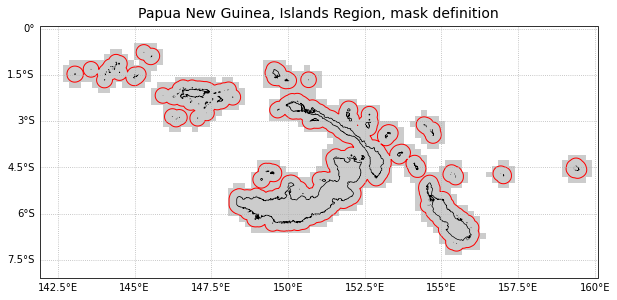

In [40]:
f, ax = plt.subplots(figsize=(10,8), subplot_kw={'projection':ccrs.PlateCarree(central_longitude=180)})

# original_shape.boundary.plot(ax=ax, transform=ccrs.PlateCarree())

# png_islands.boundary.plot(ax=ax, transform=ccrs.PlateCarree())

shape.boundary.plot(ax=ax, color='r', lw=1, transform=ccrs.PlateCarree())

original_shape.boundary.plot(ax=ax, color='k', lw=0.7, alpha=1, transform=ccrs.PlateCarree())

mask.plot(ax=ax, add_colorbar=False, transform=ccrs.PlateCarree(), alpha=0.4, cmap=plt.cm.gray)

ax.set_title(f"{country_name}, {admin_name}, mask definition", fontsize=14)

gl = ax.gridlines(draw_labels=True, linestyle=':')

gl.top_labels = False

gl.right_labels = False


In [41]:
f.savefig('./figures_paper/example_GCM_mask_definition.png', dpi=200, bbox_inches='tight', facecolor='w')
f.savefig('./figures_paper/example_GCM_mask_definition.pdf', bbox_inches='tight', facecolor='w')

In [42]:
!pwd

/home/nicolasf/operational/ICU/development/hotspots/code/ICU_Water_Watch/notebooks/verification
